# Description

**Diabetes RDD data-driven exclusion case study**

Notebook for treatment effect estimation for data-driven exclusion on diabetes Optum analysis for CLeaR 2022.

Because the data cannot be publicly shared, this notebook *will not* run, and is only for informational purposes.

# Imports

In [425]:
import linearmodels
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import os
import pickle
import pingouin as pg
import statsmodels.formula.api as smf

import sys

from linearmodels.iv import IV2SLS
from scipy import stats
from statsmodels.sandbox.regression.gmm import IV2SLS as sm_TSLS

# utils import
sys.path.append("../")

from utils.pwr import rdd_power

%matplotlib inline

# Define treatment and outcome

In [2]:
treatment_col = "dm_within_mnth"
outcome_col = "fu_first_a1c"
result_dir = "final_cforest_dm_fu_0.36"

# Load data

In [3]:
proj_path = "../"

In [4]:
rdd_dm = pd.read_pickle(os.path.join(proj_path, "results", result_dir, "rdd_dm.df"))
comp_est_df = pd.read_pickle(os.path.join(proj_path, "results", result_dir, "comp_est.df"))

# Split data and train model

- see `scripts/fit_causal_forest.py`, separate script needed to run on cluster

## Load results

In [5]:

s1_pred_comply = pd.read_pickle(os.path.join(proj_path, "results", result_dir, "s1_pred_comply.df"))
s2_pred_comply = pd.read_pickle(os.path.join(proj_path, "results", result_dir, "s2_pred_comply.df"))                               

In [6]:
s1_pred_comply['group'] = 's1'
s2_pred_comply['group'] = 's2'

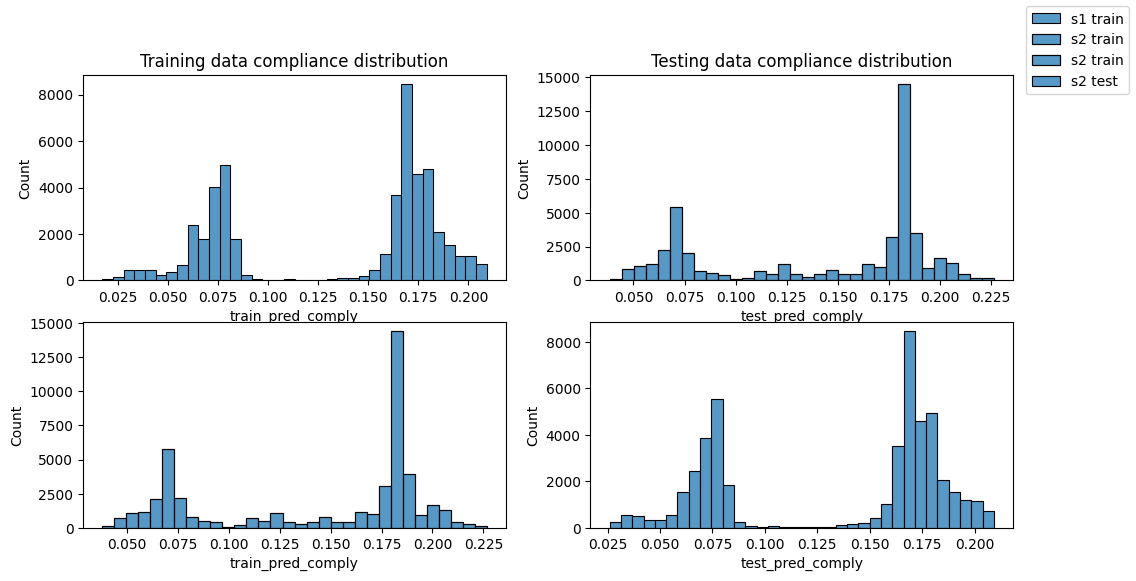

In [7]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(12,6), dpi=100)

sns.histplot(s1_pred_comply['train_pred_comply'], ax=ax1, label="s1 train")
ax1.set_title("Training data compliance distribution")
sns.histplot(s1_pred_comply['test_pred_comply'], ax=ax2, label="s2 train")
ax2.set_title("Testing data compliance distribution")
sns.histplot(s2_pred_comply['train_pred_comply'], ax=ax3, label="s2 train")
sns.histplot(s2_pred_comply['test_pred_comply'], ax=ax4, label="s2 test")
fig.legend()

In [8]:
pred_comply_df = s1_pred_comply.append(s2_pred_comply)

In [9]:
comp_est_df = comp_est_df.drop("pred_comply", axis='columns', errors='ignore')
comp_est_df = comp_est_df.merge(pred_comply_df, on='patid', how='left')

In [10]:
rdd_dm = rdd_dm.merge(comp_est_df.drop('in_bw', axis='columns'), on='patid', how='left')

In [11]:
rdd_dm['T'] = rdd_dm[treatment_col]

# Compute treatment effect estimates and power

In [14]:
tsls_formula = 'Y ~ 1 + X_lower + X_upper + [T ~ Z]'
cutoff = 6.5

## Results from all bandwidth data

In [15]:
# estimation frame
full_est_df = rdd_dm[rdd_dm['in_bw']].copy()

In [16]:
full_est_df['rounded_a1c'] = full_est_df['norm_rslt'].round(1)

In [17]:
full_est_df['Z'] = (full_est_df['norm_rslt'] >= cutoff).astype(int)

# adjusted cutpoints for TSLS
full_est_df['X_lower'] = (1-full_est_df['Z'])*(full_est_df['norm_rslt'] - cutoff)
full_est_df['X_upper'] = full_est_df['Z']*(full_est_df['norm_rslt'] - cutoff)

full_est_df['T'] = full_est_df[treatment_col]
full_est_df['Y'] = full_est_df[outcome_col]

In [183]:
96361 - 63720

32641

In [18]:
full_model = IV2SLS.from_formula(tsls_formula, full_est_df)
full_iv_results = full_model.fit(cov_type='robust')
display(full_iv_results)
rdd_power( full_iv_results.params['T'], full_iv_results.std_errors['T']**2)

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                      Y   R-squared:                     -0.0001
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0001
No. Observations:               96361   F-statistic:                    5767.6
Date:                Sun, Oct 24 2021   P-value (F-stat)                0.0000
Time:                        11:33:41   Distribution:                  chi2(3)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      6.7827     0.0501     135.29     0.0000      6.6844      6.8809
X_lower        1.1186     0.0602     18.596     0.0000      1.0007      1.2365
X_upper        1.1110     0.0599     18.549     0.0000      0.9936      1.2283
T             -0.5496     0.1698    -3.2373     0.0012     -0.8823     -0.2169
==============================================================================

Endogenous: T
Instruments: Z
Robust Covariance (Heteroskedastic)
Debiased: False
IVResults, id: 0x7fe771691e80

0.8992569147899897

In [187]:
full_cis = full_iv_results.conf_int()
full_cis['len'] = full_cis['upper'] - full_cis['lower']
full_cis

,lower,upper,len
Intercept,6.684405,6.880923,0.196518
X_lower,1.000730,1.236524,0.235794
X_upper,0.993570,1.228340,0.234770
T,-0.882331,-0.216850,0.665481


# Results from excluded data

In [19]:
# estimation frame
excl_est_df = full_est_df[full_est_df['include']].copy()

In [20]:
excl_est_df['threshold'].unique()

array([0.09461251, 0.11997519])

In [21]:
excl_est_df.shape

(63720, 60)

In [22]:
excl_model = IV2SLS.from_formula(tsls_formula, excl_est_df)
excl_iv_results = excl_model.fit(cov_type='robust')
display(excl_iv_results)
rdd_power(full_iv_results.params['T'], excl_iv_results.std_errors['T']**2)

IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                      Y   R-squared:                      0.0069
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0068
No. Observations:               63720   F-statistic:                    4226.8
Date:                Sun, Oct 24 2021   P-value (F-stat)                0.0000
Time:                        11:33:41   Distribution:                  chi2(3)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      6.7228     0.0397     169.16     0.0000      6.6449      6.8007
X_lower        1.1069     0.0579     19.118     0.0000      0.9934      1.2204
X_upper        1.1694     0.0665     17.578     0.0000      1.0390      1.2998
T             -0.4945     0.1316    -3.7577     0.0002     -0.7525     -0.2366
==============================================================================

Endogenous: T
Instruments: Z
Robust Covariance (Heteroskedastic)
Debiased: False
IVResults, id: 0x7fe76b1657c0

0.9866562967306212

In [189]:
print(rdd_power(-0.5, full_iv_results.std_errors['T']**2))
print(rdd_power(-0.5, excl_iv_results.std_errors['T']**2))

0.8377428514865262
0.9670607697202838


In [188]:
excl_cis = excl_iv_results.conf_int()
excl_cis['len'] = excl_cis['upper'] - excl_cis['lower']
excl_cis

,lower,upper,len
Intercept,6.644919,6.800704,0.155785
X_lower,0.993437,1.220395,0.226959
X_upper,1.039039,1.299818,0.260779
T,-0.752486,-0.236599,0.515887


In [23]:
excl_comply_rate = excl_est_df[(excl_est_df['Z'] == 1)]['T'].mean() - excl_est_df[(excl_est_df['Z'] == 0)]['T'].mean()
excl_comply_rate

0.17786709730889705

In [24]:
# "effective" sample size
excl_est_df.shape[0] * (excl_comply_rate**2)

2015.890798320504

In [25]:
full_comply_rate = full_est_df[(full_est_df['Z'] == 1)]['T'].mean() - full_est_df[(full_est_df['Z'] == 0)]['T'].mean()
full_comply_rate

0.14001309874308168

In [26]:
full_est_df.shape[0] * (full_comply_rate**2)

1889.0290347683244

# Result plots

In [37]:
penn_red = '#990000'
penn_blue = '#011F5B'

penn_red = '#95001A'
penn_blue = '#045EA7'
penn_light_blue = '#82afd3'
penn_gray = '#6C6F76'

## Functions

In [ ]:
def plot_treat_regression(est_df, cutoff, a1c_range, ax, scale=1, equation="T ~ Z + X_lower + X_upper",
                                                                  outcome_col='dm_within_mnth'):
    """
    Plots the treatment regression of the given est_df, tested numerical equivalency with TSLS first stage
    
    Args:
        est_df (pd.Dataframe): the data estimation dataframe
        cutoff (float)
        a1c_range (list): a list of a1c ranges. IMPORTANT: do not use np.arange because of rounding errors
    """

    trt_model = smf.ols(equation, data=est_df)
    trt_results = trt_model.fit(cov_type='HC0')
    
    # create estimation dataframe
    itt_df = pd.DataFrame()
    itt_df['Z'] = (a1c_range >= cutoff - 1e-3).astype(int)
    itt_df['X_lower'] = (1 - itt_df['Z']) * (a1c_range - cutoff)
    itt_df['X_upper'] = (itt_df['Z']) * (a1c_range - cutoff)
    
    # get predictions and confidence intervals
    trt_preds = trt_results.get_prediction(itt_df).summary_frame(alpha=0.05)

    below_x = [x for x in a1c_range if x < cutoff]
    above_x = [x for x in a1c_range if x >= cutoff]
    cut_idx = len(below_x)

    # plotting!
    a1c_group = est_df.groupby('rounded_a1c')
    a1c_rate = scale * a1c_group[outcome_col].sum() / a1c_group['patid'].count()

    rate_df = a1c_rate.to_frame().reset_index()
    #rate_df.plot(x='rounded_a1c', y=0, label='', linestyle='None',color=penn_gray, ax=ax, marker='.', alpha=0.5, legend=None)
    
    ax.plot(below_x, trt_preds[:cut_idx]['mean']*scale, color=penn_blue)
    ax.plot(above_x, trt_preds[cut_idx:]['mean']*scale, color=penn_blue)
    ax.fill_between(below_x, trt_preds[:cut_idx]['mean_ci_upper']*scale, trt_preds[:cut_idx]['mean_ci_lower']*scale, color=penn_blue, edgecolor=None, alpha=0.3)
    ax.fill_between(above_x, trt_preds[cut_idx:]['mean_ci_upper']*scale, trt_preds[cut_idx:]['mean_ci_lower']*scale, color=penn_blue, edgecolor=None, alpha=0.3)


# test
# fig, ax = plt.subplots()
# a1c_range = np.round(np.arange(5.5, 7.65, 0.1), 1)
# print(a1c_range)
# est_df = full_est_df[full_est_df['norm_rslt'] > 5.45]
# plot_treat_regression(est_df, cutoff, a1c_range, ax, scale=1)

In [ ]:
def plot_outcome_regression(est_df, cutoff, a1c_range, ax, scale=1):
    """
    Plots outcome regression, using the statsmodels implementation of TSLS for confidence intervals.
    """
    est_df['const'] = 1
    sm_iv = sm_TSLS(endog=est_df['Y'],
                          exog=est_df[['T', 'X_lower', 'X_upper', 'const']],
                          instrument=est_df[['Z', 'X_lower', 'X_upper', 'const']])
    
    sm_results = sm_iv.fit()
    itt_df = pd.DataFrame()
    itt_df['Z'] = (a1c_range >= cutoff - 1e-3).astype(int)
    itt_df['X_lower'] = (1 - itt_df['Z']) * (a1c_range - cutoff)
    itt_df['X_upper'] = (itt_df['Z']) * (a1c_range - cutoff)
    itt_df['const'] = 1
    # get predictions and confidence intervals
    iv_preds = sm_results.get_prediction(itt_df).summary_frame(alpha=0.05)
    
    below_x = [x for x in a1c_range if x < cutoff]
    above_x = [x for x in a1c_range if x >= cutoff]
    cut_idx = len(below_x)

    # plotting!
    ax.plot(below_x, iv_preds[:cut_idx]['mean']*scale, color=penn_blue)

    ax.plot(above_x, iv_preds[cut_idx:]['mean']*scale, color=penn_blue)
    ax.fill_between(below_x, iv_preds[:cut_idx]['mean_ci_upper']*scale, iv_preds[:cut_idx]['mean_ci_lower']*scale, color=penn_blue, edgecolor=None, alpha=0.3)
    ax.fill_between(above_x, iv_preds[cut_idx:]['mean_ci_upper']*scale, iv_preds[cut_idx:]['mean_ci_lower']*scale, color=penn_blue, edgecolor=None, alpha=0.3)

# test
# fig, ax = plt.subplots()
# a1c_range = np.round(np.arange(5.5, 7.65, 0.1), 1)
# print(a1c_range)
# est_df = full_est_df[full_est_df['norm_rslt'] > 5.45]
# plot_outcome_regression(est_df, cutoff, a1c_range, ax, scale=1)

## Create subplots

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(8,4), dpi=150);
fig.patch.set_facecolor('white');

## Full data

In [483]:
a1c_range = np.round(np.arange(min(full_est_df['rounded_a1c']), max(full_est_df['rounded_a1c']) + 0.05, 0.1), 1)
a1c_range

array([6.1, 6.2, 6.3, 6.4, 6.5, 6.6, 6.7, 6.8])

In [484]:
ax1.clear()

plot_treat_regression(full_est_df, cutoff, a1c_range, ax=ax1, scale=1, outcome_col=treatment_col)

ax1.axvline(x=6.45, color=penn_red, label='diabetic criteria', ls='--')
ax1.legend(loc='lower right')
ax1.set_ylabel("30 day diabetes\ndiagnosis rate", fontsize=12);
ax1.set_xlabel("")
ax1.set_ylim(0.1, 0.45)
ax1.tick_params(top=False)
ax1.set_yticks([0.2, 0.4])
ax1.set_xticks([6.1, 6.8])


## Excluded data

In [485]:
ax2.clear()
plot_treat_regression(excl_est_df, cutoff, a1c_range, ax=ax2, scale=1, outcome_col=treatment_col)

ax2.axvline(x=6.45, color=penn_red, ls='--')
ax2.set_xlabel("")
ax2.set_ylabel("");
ax2.set_ylim(0.1, 0.45)
ax2.set_yticks([0.2, 0.4])
ax2.tick_params(top=False, right=False)
ax2.set_xticks([6.1, 6.8])

## Outcome regressions

### Full

In [486]:
full_est_df['outcome_pred'] = full_iv_results.predict()

In [487]:
full_outcome_preds = full_est_df[((full_est_df['T'] == 0) & (full_est_df['Z'] == 0)) |
                                 ((full_est_df['T'] == 1) & (full_est_df['Z'] == 1))]

In [488]:
full_outcome_preds = full_outcome_preds.drop_duplicates('rounded_a1c')[['rounded_a1c', 'outcome_pred']]
full_outcome_preds = full_outcome_preds.sort_values(by='rounded_a1c')
# get intention to treat
full_outcome_preds = full_outcome_preds.reset_index(drop=True)
full_outcome_preds.loc[full_outcome_preds['rounded_a1c'] >= cutoff]

,rounded_a1c,outcome_pred
4,6.5,6.233074
5,6.6,6.344169
6,6.7,6.455265
7,6.8,6.566360


In [489]:
scale=1
ax3.clear()
full_group = full_est_df.groupby('rounded_a1c')
full_rate = scale * full_group['Y'].sum() / full_group['patid'].count()

full_rate_df = full_rate.to_frame().reset_index()


plot_outcome_regression(full_est_df, cutoff, a1c_range, ax3)
ax3.axvline(x=6.45, color=penn_red, ls='--')
ax3.set_yticks([6.1, 6.7])
ax3.set_xticks([6.1, 6.8])
ax3.tick_params(top=False, right=False)

ax3.set_xlabel("A1C %", fontsize=12)
ax3.set_ylabel("Followup A1C %", fontsize=12);

### Excluded

In [490]:
excl_est_df['outcome_pred'] = excl_iv_results.predict()

In [491]:
excl_outcome_preds = excl_est_df[((excl_est_df['T'] == 0) & (excl_est_df['Z'] == 0)) |
                                 ((excl_est_df['T'] == 1) & (excl_est_df['Z'] == 1))]

In [492]:
excl_outcome_preds = excl_outcome_preds.drop_duplicates('rounded_a1c')[['rounded_a1c', 'outcome_pred']]
excl_outcome_preds = excl_outcome_preds.sort_values(by='rounded_a1c')
# get intention to treat
excl_outcome_preds = excl_outcome_preds.reset_index(drop=True)
excl_outcome_preds.loc[excl_outcome_preds['rounded_a1c'] >= cutoff]

,rounded_a1c,outcome_pred
4,6.5,6.228269
5,6.6,6.345212
6,6.7,6.462155
7,6.8,6.579098


In [493]:
scale=1
excl_group = excl_est_df.groupby('rounded_a1c')
excl_rate = scale * excl_group['Y'].sum() / excl_group['patid'].count()

excl_rate_df = excl_rate.to_frame().reset_index()
ax4.clear()

plot_outcome_regression(excl_est_df, cutoff, a1c_range, ax4)
ax4.tick_params(top=False, right=False)

#ax4.set_xlim(5.5, 7.5)
#ax4.set_ylim(6, 7)
ax4.axvline(x=6.45, color=penn_red, ls='--')
#ax4.legend(loc='lower right')
ax4.set_xlabel("A1C %", fontsize=12)
ax4.set_yticks([6.1, 6.7])
ax4.set_xticks([6.1, 6.8])

## Figure 5

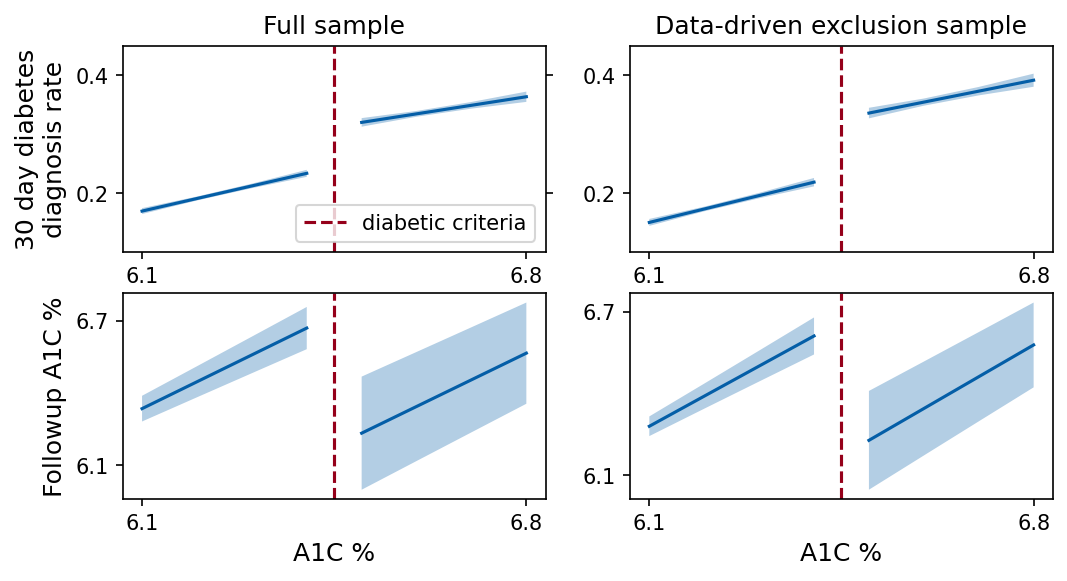

In [494]:
ax1.set_title("Full sample")
ax2.set_title("Data-driven exclusion sample")
fig

In [495]:
fig.savefig("frdd_result_no_points.png", dpi=300, bbox_inches='tight')

# Characterizing our sample

In [417]:
in_df = full_est_df[full_est_df['include'] == True]
out_df = full_est_df[full_est_df['include'] == False]

In [420]:
out_df[['gdr_cd']].value_counts() / out_df.shape[0]

gdr_cd
F         0.503906
M         0.496094
dtype: float64

In [421]:
in_df[['gdr_cd']].value_counts() / in_df.shape[0]

gdr_cd
F         0.532627
M         0.467373
dtype: float64

In [422]:
in_df[['bus']].value_counts() / in_df.shape[0]

bus
MCR    0.543613
COM    0.456387
dtype: float64

In [423]:
out_df[['bus']].value_counts() / out_df.shape[0]

bus
COM    0.788855
MCR    0.211145
dtype: float64

In [424]:
full_est_df.groupby("include")[['age_x', 'bus', 'days_from_2001']].describe().transpose()

include                      False         True 
age_x          count  32641.000000  63720.000000
               mean      55.996936     62.929692
               std       11.141736     12.463665
               min       18.000000     18.000000
               25%       49.000000     55.000000
               50%       56.000000     65.000000
               75%       63.000000     71.000000
               max       83.000000     88.000000
days_from_2001 count  32641.000000  63720.000000
               mean    1789.490028   4419.911095
               std      962.202746    631.439708
               min        1.000000   2950.000000
               25%     1113.000000   3974.000000
               50%     1837.000000   4505.000000
               75%     2663.000000   4950.000000
               max     3330.000000   5474.000000

In [213]:
pd.to_datetime('2001-01-01') + pd.DateOffset(days=4420)

Timestamp('2013-02-07 00:00:00')

In [214]:
pd.to_datetime('2001-01-01') + pd.DateOffset(days=1789)

Timestamp('2005-11-25 00:00:00')